# data load

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV, StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, precision_recall_fscore_support
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
import logging

RANDOM_SEED = 42
save_data_path = "./results"
os.makedirs(save_data_path, exist_ok=True)

# define of class

In [12]:
class data_loader:
    def __init__(self, X_path, sample_annotation_file):
        super().__init__()
        
        self.target_label_name = 'Population code'
        self.notusing_lables = ['IBS,MSL', 'GBR', 'ASW', 'ACB', 'GIH', 'CHB', 'STU', 'ITU']
        data_split = [0.6, 0.2, 0.2]  # train, val, test

        self.X = np.load(X_path)
        self.sample_annotation_df = pd.read_csv(sample_annotation_file, sep='\t')
        self.y = self.sample_annotation_df[self.target_label_name]
        logging.info(f"[progress] Read data done. X.shape: {self.X.shape}, y.shape: {self.y.shape}")

        self.drop_notusing_sample(notusing_list=self.notusing_lables)
        self.y_encoded, self.label_mapping = self.encode_y()
        self.train_indices, self.val_indices, self.test_indices = self.split_dataset(val_size=data_split[1], test_size=data_split[2])

        logging.info(f" - Data_split: train_set (n={len(self.train_indices)}), val_set (n={len(self.val_indices)}), test_set (n={len(self.test_indices)})")
        assert self.X.shape[0] == self.y.shape[0]
        assert self.X.shape[0] == self.y_encoded.shape[0]
        assert self.test_index_coverage(self.train_indices, self.val_indices, self.test_indices, self.X.shape[0])

    def test_index_coverage(self, train_indices, val_indices, test_indices, total_length):
        combined_indices = np.concatenate((train_indices, val_indices, test_indices))
        unique_indices = np.unique(combined_indices)
        expected_indices = np.arange(total_length)
        if np.array_equal(np.sort(unique_indices), expected_indices):
            return True
        else:
            missing_indices = np.setdiff1d(expected_indices, unique_indices)
            extra_indices = np.setdiff1d(unique_indices, expected_indices)
            print(f"Missing indices: {missing_indices}")
            print(f"Extra indices: {extra_indices}")
            return False

    def drop_notusing_sample(self, notusing_list):
        indices_to_drop = self.sample_annotation_df[self.sample_annotation_df[self.target_label_name].isin(notusing_list)].index
        if not indices_to_drop.empty:
            self.sample_annotation_df = self.sample_annotation_df.drop(indices_to_drop)
            self.y = self.y.drop(indices_to_drop)
            self.X = np.delete(self.X, indices_to_drop, axis=0)
        logging.info(f"[progress] Dropped {len(indices_to_drop)} samples from the dataset. X.shape: {self.X.shape}, y.shape: {self.y.shape}")

    def encode_y(self):
        label_encoder = LabelEncoder()
        y_encoded = label_encoder.fit_transform(self.y)
        label_mapping = dict(zip(label_encoder.transform(label_encoder.classes_), label_encoder.classes_))
        return y_encoded, label_mapping

    def split_dataset(self, val_size=0.15, test_size=0.15):
        sss = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=RANDOM_SEED)
        train_val_idx, test_indices = next(sss.split(self.X, self.y_encoded))
        adjusted_val_size = val_size / (1 - test_size)
        sss_val = StratifiedShuffleSplit(n_splits=1, test_size=adjusted_val_size, random_state=RANDOM_SEED)
        train_idx, val_idx = next(sss_val.split(self.X[train_val_idx], self.y_encoded[train_val_idx]))
        train_indices = train_val_idx[train_idx]
        val_indices = train_val_idx[val_idx]
        return train_indices, val_indices, test_indices

    def get_data(self):
        return (self.X, np.array(self.y), self.y_encoded), (self.train_indices, self.val_indices, self.test_indices), self.label_mapping


# data load

In [16]:
feature_data_path = '/project/datacamp/team11/data' 
# target_feature = "preprocessed/merged_support3_variance_0.1_random_1M"
target_feature = "preprocessed/merged_random_1k" 
target_feature_suffix = "_matrix.npy"
sample_annotation_file = os.path.join(feature_data_path, "igsr-1000 genomes 30x on grch38.tsv")

dataset = data_loader(os.path.join(feature_data_path, target_feature + target_feature_suffix), 
                      sample_annotation_file)
(X, y_original, y_encoded), (train_indices, val_indices, test_indices), label_mapping = dataset.get_data()


# train model

In [17]:
X_train, X_val, X_test = X[train_indices], X[val_indices], X[test_indices]
y_train, y_val, y_test = y_encoded[train_indices], y_encoded[val_indices], y_encoded[test_indices]
y_labels_train, y_labels_val, y_labels_test = y_original[train_indices], y_original[val_indices], y_original[test_indices]


In [18]:
def train_ML(X_train, y_train, X_val, y_val, X_test, params, method="SVM"):
    if method == "SVM":
        model = SVC(random_state=42)
        grid_search = GridSearchCV(estimator=model, param_grid=params, cv=5, scoring='accuracy', verbose=1)
        grid_search.fit(X_train, y_train)
        model = grid_search.best_estimator_
        y_pred_train = model.predict(X_train)
        y_pred_val = model.predict(X_val)
        y_pred_test = model.predict(X_test)
        return y_pred_train, y_pred_val, y_pred_test, model
    else:
        raise ValueError(f"Unsupported method: {method}")


params = {'C': [0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10], 'kernel': ['linear']}

y_pred_train, y_pred_val, y_pred_test, model = train_ML(X_train, y_train, X_val, y_val, X_test, params, method="SVM")

    



Fitting 5 folds for each of 8 candidates, totalling 40 fits


# result

Overall Accuracy: 47.49%


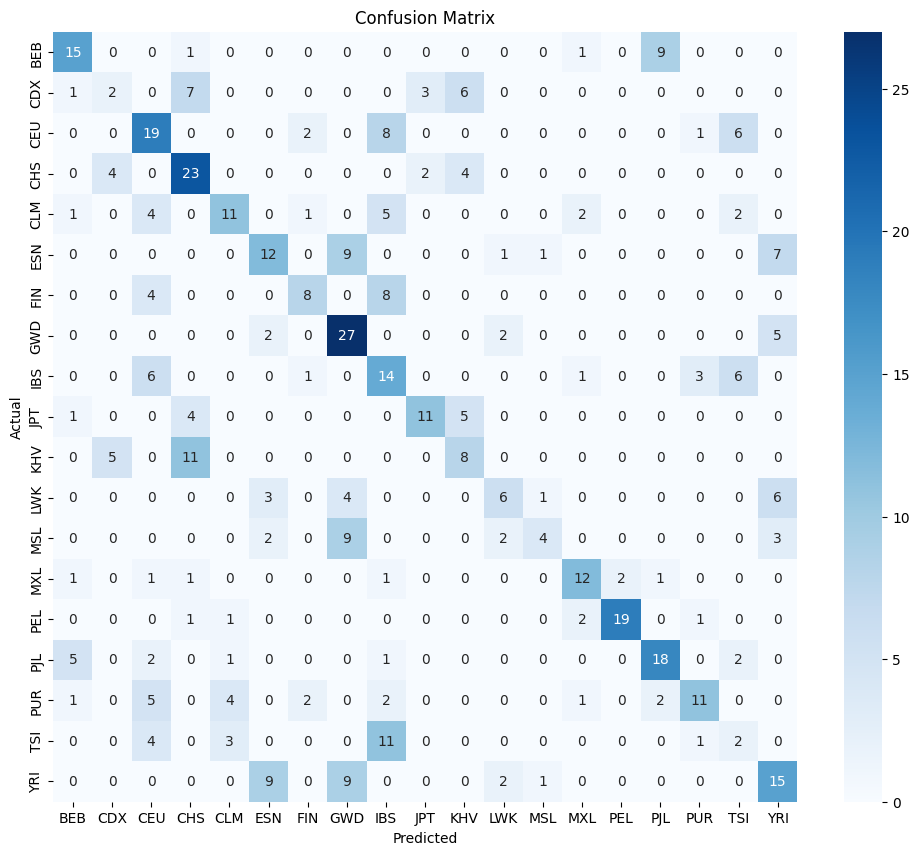

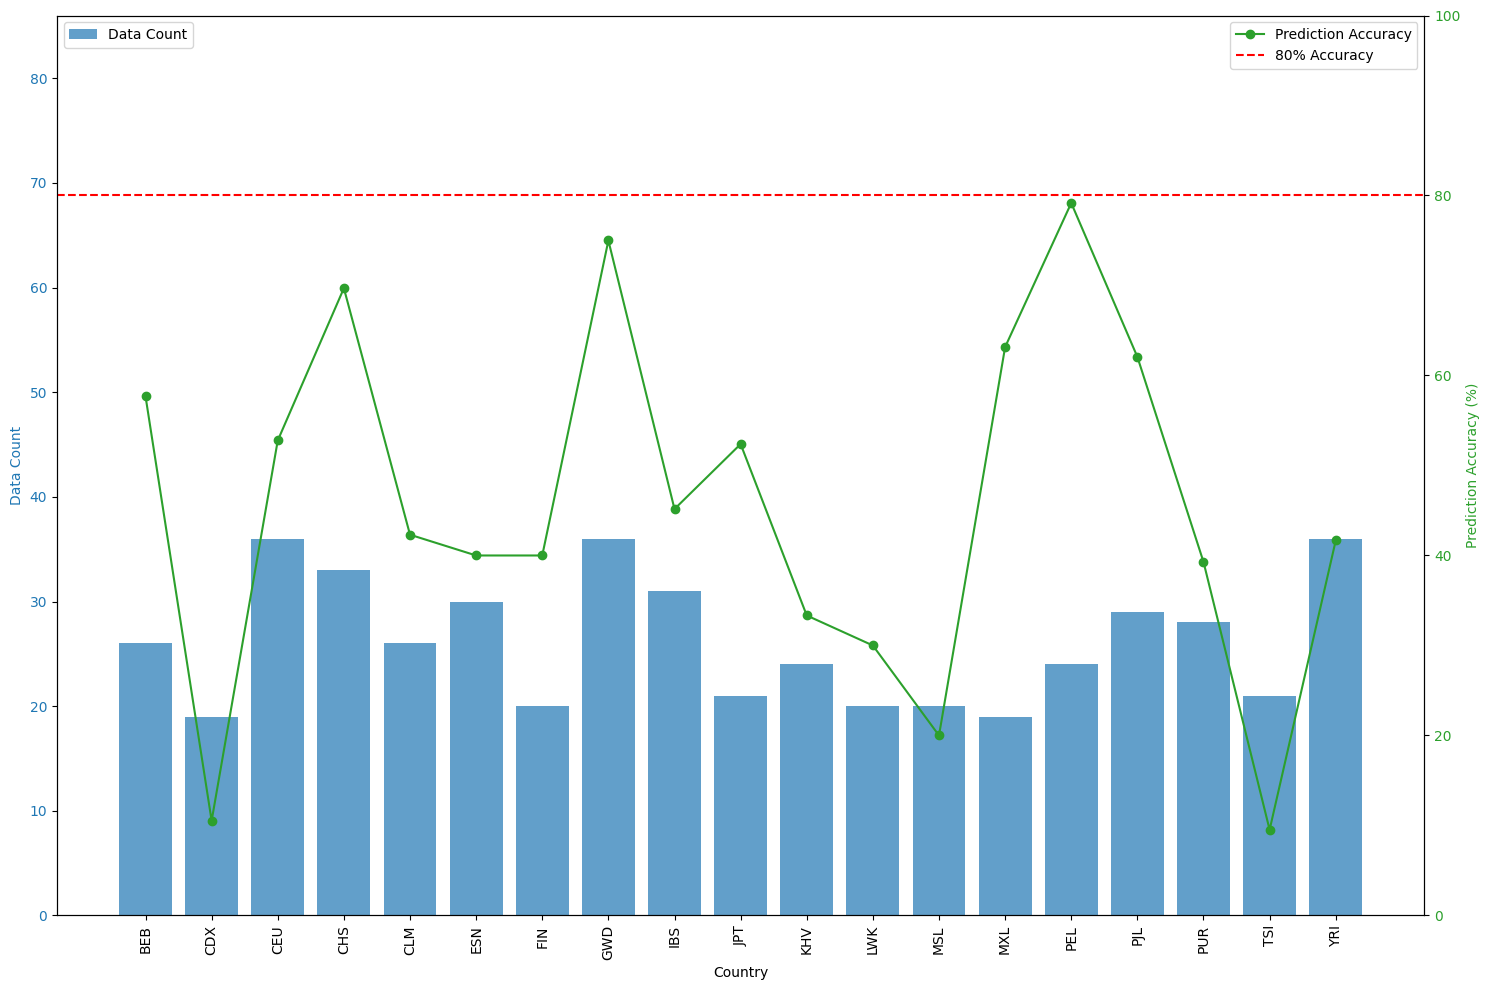

In [19]:
overall_accuracy = accuracy_score(y_test, y_pred_test) * 100
print(f"Overall Accuracy: {overall_accuracy:.2f}%")

def plot_confusion_matrix(y_true, y_pred, labels, file_path=None):
    conf_matrix = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(12, 10))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    if file_path:
        plt.savefig(file_path, dpi=300, bbox_inches='tight')
    plt.show()

plot_confusion_matrix(y_test, y_pred_test, list(label_mapping.values()), file_path="confusion_matrix.png")

unique_countries = np.unique(y_labels_test)
country_data_count = []
country_accuracies = []

for country in unique_countries:
    country_indices = np.where(y_labels_test == country)[0]
    X_country = X_test[country_indices]
    y_country = y_test[country_indices]
    y_pred_country = y_pred_test[country_indices]

    country_data_count.append(len(country_indices))

    if len(y_country) > 0:
        accuracy = accuracy_score(y_country, y_pred_country) * 100
        country_accuracies.append(accuracy)
    else:
        country_accuracies.append(np.nan)

def plot_country_data_and_accuracies(countries, data_count, accuracies, file_path=None):
    fig, ax1 = plt.subplots(figsize=(15, 10))

    color = 'tab:blue'
    ax1.set_xlabel('Country')
    ax1.set_ylabel('Data Count', color=color)
    ax1.bar(countries, data_count, color=color, alpha=0.7, label='Data Count')
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.set_ylim(0, max(data_count) + 50)
    plt.xticks(rotation=90)

    ax2 = ax1.twinx()  
    color = 'tab:green'
    ax2.set_ylabel('Prediction Accuracy (%)', color=color)
    ax2.plot(countries, accuracies, color=color, marker='o', label='Prediction Accuracy')
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.set_ylim(0, 100)
    ax2.axhline(y=80, color='r', linestyle='--', label='80% Accuracy')

    fig.tight_layout()  
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')

    if file_path:
        plt.savefig(file_path, dpi=300, bbox_inches='tight')
    plt.show()

plot_country_data_and_accuracies(unique_countries, country_data_count, country_accuracies, file_path="country_data_and_accuracy.png")

